In [1]:
import json
import pandas as pd
import os
from vega import VegaLite
%run utils

benchmark_dir = "../benchmarks"

def load_input_table(fname):
    with open(os.path.join(benchmark_dir, fname), "r") as f:
        benchmark = json.load(f)
        input_data = benchmark["input_data"]
        df = pd.DataFrame.from_records(input_data)
        df = load_and_clean_table(df)
        return df

   Actual Profits  Number of Units   Quarter
0            3358               23  Quarter1
1            3829               27  Quarter2
2            2374               15  Quarter3
3            3373               43  Quarter4


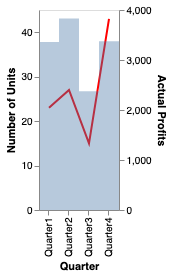

In [51]:
df1 = load_input_table("001.json")
#df = pd.melt(df, id_vars='Quarter', value_vars=["Actual Profits", "No. of Units"])

print(df1)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [
        {
            "mark": {"stroke": "red", "type": "line"},
            "encoding": {
                "y": {"field": "Number of Units", "type": "quantitative"},
                "x": { "field": "Quarter", "type": "nominal" }
            }
        }, 
        {
            "mark": {"opacity": 0.4, "type": "bar"},
            "encoding": {
                "y": {"type": "quantitative", "field": "Actual Profits"},
                "x": { "field": "Quarter", "type": "nominal" }
            }
        }
  ],
  "resolve": {"scale": {"y": "independent"}}
}, df1)

     Month          variable  value
0   Apr-15        Low (<50%}  0.500
1   May-15        Low (<50%}  0.500
2   Jun-15        Low (<50%}  0.500
3   Jul-15        Low (<50%}  0.500
4   Aug-15        Low (<50%}  0.500
5   Sep-15        Low (<50%}  0.500
6   Oct-15        Low (<50%}  0.500
7   Nov-15        Low (<50%}  0.500
8   Dec-15        Low (<50%}  0.500
9   Jan-16        Low (<50%}  0.500
10  Feb-16        Low (<50%}  0.500
11  Mar-16        Low (<50%}  0.500
12  Apr-15  Medium (50%-80%}  0.300
13  May-15  Medium (50%-80%}  0.300
14  Jun-15  Medium (50%-80%}  0.300
15  Jul-15  Medium (50%-80%}  0.300
16  Aug-15  Medium (50%-80%}  0.300
17  Sep-15  Medium (50%-80%}  0.300
18  Oct-15  Medium (50%-80%}  0.300
19  Nov-15  Medium (50%-80%}  0.300
20  Dec-15  Medium (50%-80%}  0.300
21  Jan-16  Medium (50%-80%}  0.300
22  Feb-16  Medium (50%-80%}  0.300
23  Mar-16  Medium (50%-80%}  0.300
24  Apr-15       High (>80%)  0.200
25  May-15       High (>80%)  0.200
26  Jun-15       High (>80%)

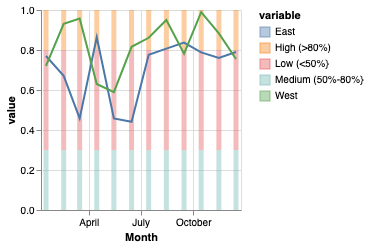

In [52]:
df2 = load_input_table("002.json")

df2 = pd.melt(df2, id_vars='Month', value_vars=["Low (<50%}", "Medium (50%-80%}", "High (>80%)", "East", "West"])

print(df2)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "layer": [
        {
            "mark": {"opacity": 0.4, "type": "bar"},
            "transform": [{"filter": "datum.variable != \"East\" && datum.variable != \"West\""}],
            "encoding": {
                "color": {"field": "variable", "type": "nominal"},
                "y": {"field": "value", "type": "quantitative"},
                "x": { "field": "Month", "type": "temporal" }
            }
        }, 
        {
            "mark": {"type": "line", "stroke": "red"},
            "transform": [{"filter": "datum.variable == \"East\" || datum.variable == \"West\""}],
            "encoding": {
                "color": {"field": "variable", "type": "nominal"},
                "y": {"field": "value", "type": "quantitative"},
                "x": { "field": "Month", "type": "temporal" }
            }
        }
  ]
}, df2)

    Month  Net Cash Flow
0   Start          80000
1     Apr          -5003
2     May         -16700
3     Jun          48802
4     Jul         -11198
5     Aug         -35260
6     Sep          18220
7     Oct         -23840
8     Nov          43250
9     Dec         -18280
10    Jan          26670
11    Feb          15000
12    Mar          24750
    Month  Net Cash Flow  Net Cash Flow Sum       c      d
0   Start          80000              80000       0  False
1     Apr          -5003              74997   80000   True
2     May         -16700              58297   74997   True
3     Jun          48802             107099   58297  False
4     Jul         -11198              95901  107099   True
5     Aug         -35260              60641   95901   True
6     Sep          18220              78861   60641  False
7     Oct         -23840              55021   78861   True
8     Nov          43250              98271   55021  False
9     Dec         -18280              79991   98271   True
1

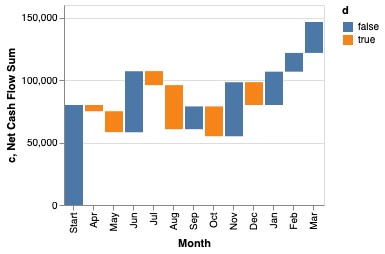

In [4]:
df3 = load_input_table("003.json")

print(df3)

df3_1 = df3["Net Cash Flow"].cumsum()
df3 = df3.join(df3_1, lsuffix='', rsuffix=' Sum')
df3 = df3.assign(c=df3["Net Cash Flow Sum"]-df3["Net Cash Flow"])
df3 = df3.assign(d=df3["c"]>df3["Net Cash Flow Sum"])

print(df3)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": {"field": "Month", "type": "nominal", "sort": "none"},
        "y2": {
          "field": "Net Cash Flow Sum",
          "type": "quantitative"    
        },
        "y": {"field": "c", "type": "quantitative"},
        "color": {"field": "d", "type": "nominal"},
    }
}, df3)

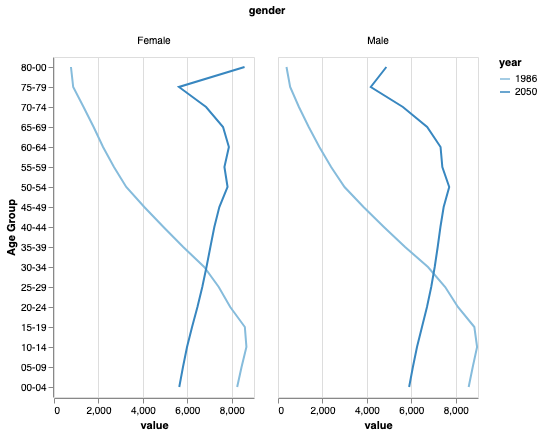

In [5]:
df4 = load_input_table("004.json")

df4 = pd.melt(df4, id_vars='Age Group', value_vars=["Female-1986", "Female-2050", "Male-1986", "Male-2050"])

split_col = df4["variable"].str.split("-", expand=True)
df4["gender"] = split_col[0]
df4["year"] = split_col[1]

#print(df4)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "line",
    "encoding": {
        "y": {"field": "Age Group", "type": "nominal", "sort": "descending"},
        "x": {
          "field": "value",
          "type": "quantitative"    
        },
        "column": {"field": "gender", "type": "nominal"},
        "color": {"field": "year","type": "ordinal"},
    }
}, df4)

   Month variable    value
0    Jan     Cost   6.0000
1    Feb     Cost  15.0000
2    Mar     Cost  24.0000
3    Apr     Cost  33.0000
4    May     Cost  42.0000
5    Jun     Cost  51.0000
6    Jan   Profit   4.0000
7    Feb   Profit   5.0000
8    Mar   Profit   6.0000
9    Apr   Profit   7.0000
10   May   Profit   8.0000
11   Jun   Profit   9.0000
12   Jan      ROI   0.6667
13   Feb      ROI   0.3333
14   Mar      ROI   0.2500
15   Apr      ROI   0.2121
16   May      ROI   0.1905
17   Jun      ROI   0.1765
18   Jan    Sales  10.0000
19   Feb    Sales  20.0000
20   Mar    Sales  30.0000
21   Apr    Sales  40.0000
22   May    Sales  50.0000
23   Jun    Sales  60.0000


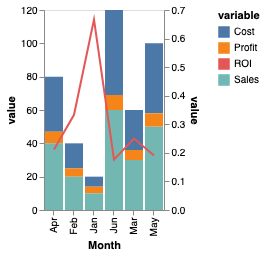

In [6]:
df5 = load_input_table("005.json")

df5 = pd.melt(df5, id_vars='Month', value_vars=["Cost", "Profit", "ROI", "Sales"])

print(df5)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {
        "x": { "field": "Month", "type": "nominal" }
    },
    "layer": [
        {
            "mark": {"type": "bar"},
            "transform": [{"filter": "datum.variable != \"ROI\""}],
            "encoding": {
                "color": {"field": "variable", "type": "nominal"},
                "y": {"field": "value", "type": "quantitative"}
            }
        },
        {
            "mark": {"type": "line", "stroke": "red"},
            "transform": [{"filter": "datum.variable == \"ROI\""}],
            "encoding": {
                "color": {"field": "variable", "type": "nominal"},
                "y": {"field": "value", "type": "quantitative"}
            }
        }
  ],
  "resolve": {"scale": {"y": "independent"}}
}, df5)

     Bucket  variable  value
0  Bucket E    Actual    115
1  Bucket D    Actual     90
2  Bucket C    Actual    115
3  Bucket B    Actual    140
4  Bucket A    Actual    150
5  Bucket E  Budgeted    100
6  Bucket D  Budgeted    100
7  Bucket C  Budgeted    125
8  Bucket B  Budgeted    125
9  Bucket A  Budgeted    140


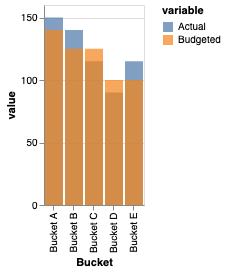

In [7]:
df6 = load_input_table("006.json")

df6 = pd.melt(df6, id_vars='Bucket', value_vars=["Actual", "Budgeted"])

print(df6)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {"type": "bar"},
    "transform": [{"filter": "datum.variable != \"ROI\""}],
    "encoding": {
        "color": {"field": "variable", "type": "nominal"},
        "y": {"field": "value", "type": "quantitative", "stack": "null"},
        "x": { "field": "Bucket", "type": "nominal" },
        "opacity": {"value": 0.7}
    }
}, df6)

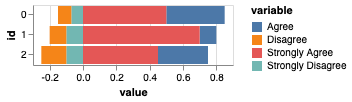

In [8]:
df7 = load_input_table("007.json")

df7['id'] = df7.index
df7 = pd.melt(df7, id_vars='id', value_vars=["Strongly Disagree", "Agree", "Disagree", "Strongly Agree"])
df7['value'].mask(df7['variable'] == "Disagree", -df7["value"], inplace=True)
df7['value'].mask(df7['variable'] == "Strongly Disagree", -df7["value"], inplace=True)



VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {"type": "bar"},
    "encoding": {
        "color": {"field": "variable", "type": "nominal"},
        "y": {"field": "id", "type": "nominal"},
        "x": { "field": "value", "type": "quantitative"}    
    }
}, df7)

Value variable  lower range  means  stddev  upper range
0           Y1         0.39   0.52  0.1328         0.66
1           Y2         0.44   0.57  0.1321         0.70
2           Y3         0.47   0.60  0.1303         0.73
3           Y4         0.50   0.63  0.1266         0.75
4           Y5         0.51   0.63  0.1225         0.75


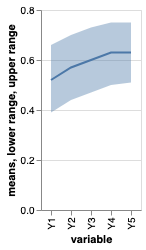

In [9]:
df8 = load_input_table("008.json")

# gather(dat, "col1", "col2", -Value) %>% spread(Value, col2)
df8 = pd.melt(df8, id_vars='Value', value_vars=["Y1", "Y2", "Y3", "Y4", "Y5"])
df8 = df8.pivot(index='variable',columns='Value', values='value').reset_index()
df8 = load_and_clean_table(df8)

print(df8)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {
        "x": { "field": "variable", "type": "nominal" }
    },
    "layer": [
        {
            "mark": "line",
            "encoding": {
                "y": {"field": "means", "type": "quantitative"}
            }
        }, 
        {
            "mark": {"opacity": 0.4, "type": "area"},
            "encoding": {
                "y": {"type": "quantitative", "field": "lower range"},
                "y2": {"type": "quantitative", "field": "upper range"}
            }
        }
  ]
}, df8)

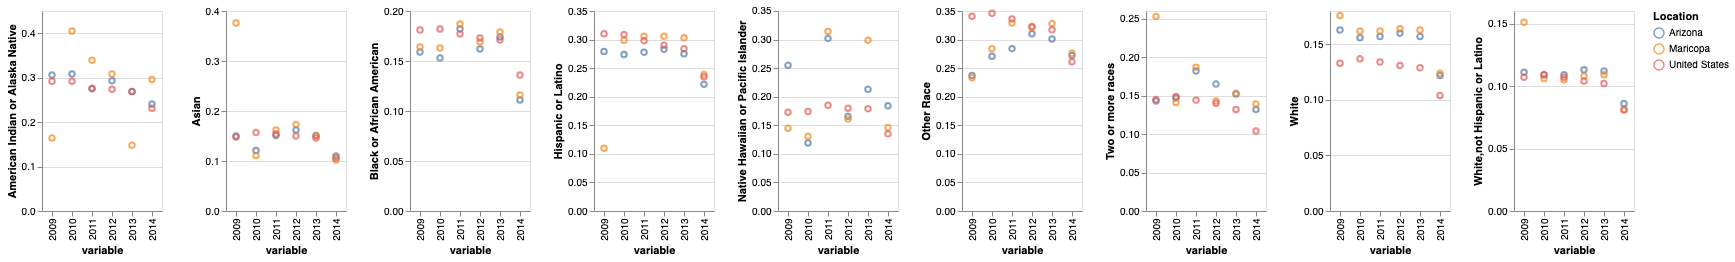

In [10]:
df9 = load_input_table("009.json")
df9 = pd.melt(df9, id_vars=['Location', 'Rae'], value_vars=["2009", "2010", "2011", "2012", "2013", "2014"])
df9 = df9.pivot_table(index=["Location", "variable"], columns='Rae', values='value').reset_index()

#print(df9)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "repeat": ["American Indian or Alaska Native", "Asian", "Black or African American", 
               "Hispanic or Latino", "Native Hawaiian or Pacific Islander", "Other Race",
               "Two or more races", "White", "White,not Hispanic or Latino"],
    "columns": 10,
  "spec": {
    "encoding": {
        "x": { "field": "variable", "type": "nominal" }
    },
    "layer": [
        {
            "mark": "point",
            "encoding": {
                "y": {"field": {"repeat": "repeat"}, "type": "quantitative"},
                "color": {"field": "Location", "type": "nominal"}
            }
        }
    ]
  }
}, df9)

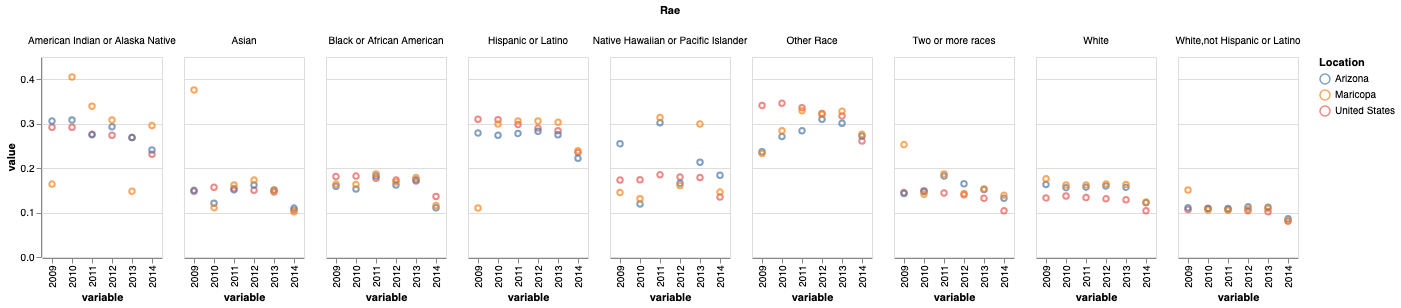

In [46]:
df9 = load_input_table("009.json")
df9 = pd.melt(df9, id_vars=['Location', 'Rae'], value_vars=["2009", "2010", "2011", "2012", "2013", "2014"])

#print(df9)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
            "mark": "point",
            "encoding": {
                "x": { "field": "variable", "type": "nominal" },
                "y": {"field": "value", "type": "quantitative"},
                "color": {"field": "Location", "type": "nominal"},
                "column": {"field": "Rae", "type": "nominal"}
            }
}, df9)

      Class variable  value
0  Literacy     Fall     34
1  Language     Fall     63
2      Math     Fall     67
3   Science     Fall     92
4      Arts     Fall     96
5  Literacy   Spring     69
6  Language   Spring     77
7      Math   Spring     75
8   Science   Spring     98
9      Arts   Spring    100


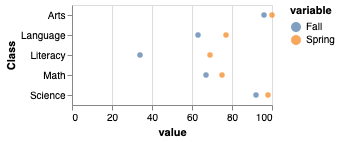

In [12]:
df10 = load_input_table("010.json")
df10 = pd.melt(df10, id_vars="Class", value_vars=['Fall', 'Spring'])

print(df10)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "circle",
    "encoding": {
        "y": {"field": "Class", "type": "nominal"},
        "x": { "field": "value", "type": "quantitative" },
        "color": {"field": "variable", "type": "nominal"}
    }

}, df10)

C1       variable        C2    Q1    Q2    Q3
0            APAC   Adopted  0.38  0.27  0.59
1            APAC   Engaged  0.47  0.37  0.75
2            APAC   Pitched  0.45  0.35  0.74
3            APAC  Targeted  0.48  0.39  0.87
4            EMEA   Adopted  0.52  0.42  0.62
5            EMEA   Engaged  0.65  0.54  0.78
6            EMEA   Pitched  0.59  0.50  0.72
7            EMEA  Targeted  0.66  0.56  0.91
8           LATAM   Adopted  0.31  0.26  0.53
9           LATAM   Engaged  0.48  0.41  0.80
10          LATAM   Pitched  0.44  0.37  0.73
11          LATAM  Targeted  0.48  0.43  0.95
12  North America   Adopted  0.36  0.31  0.40
13  North America   Engaged  0.52  0.43  0.55
14  North America   Pitched  0.45  0.39  0.50
15  North America  Targeted  0.56  0.50  0.70


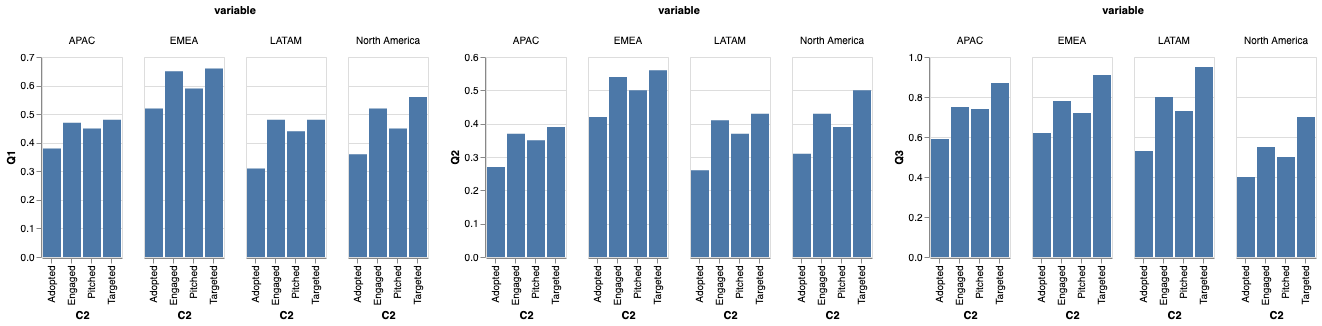

In [13]:
df11 = load_input_table("011.json")

df11 = pd.melt(df11, id_vars=["C1", "C2"], value_vars=["EMEA", "LATAM", "North America", "APAC"])
df11 = df11.pivot_table(index=["variable", "C2"], columns='C1', values='value').reset_index()

print(df11)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "repeat": ["Q1", "Q2", "Q3"],
    "columns": 3,
    "spec": {
        "mark": "bar",
        "encoding": {
            "y": {"field": {"repeat": "repeat"}, "type": "quantitative"},
            "x": { "field": "C2", "type": "nominal" },
            "column": {"field": "variable", "type": "nominal"}      
        }
    }
}, df11)

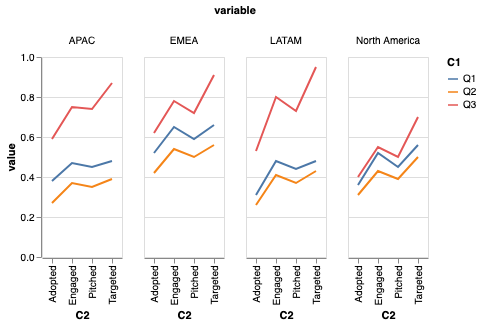

In [14]:
df12 = load_input_table("012.json")

df12 = pd.melt(df12, id_vars=["C1", "C2"], value_vars=["EMEA", "LATAM", "North America", "APAC"])

# print(df12)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "line",
    "encoding": {
        "y": {"field": "value", "type": "quantitative"},
        "x": { "field": "C2", "type": "nominal" },
        "column": {"field": "variable", "type": "nominal"},
        "color": {"field": "C1", "type": "nominal"}
    }
}, df12)

   Totals Value  alpha  beta  gamma
0       7     A      2     2      3
1       8     B      2     3      3
2       9     c      3     3      3
3       9     D      3     4      2
4       9     E      4     3      2


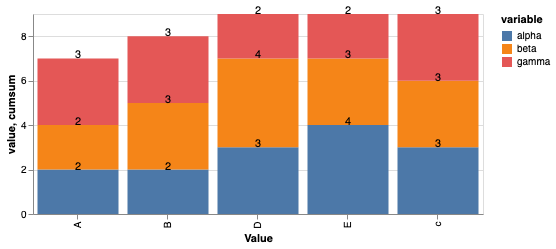

In [15]:
df13 = load_input_table("013.json")

print(df13)

df13 = pd.melt(df13, id_vars=["Totals", "Value"], value_vars=["alpha", "beta", "gamma"])
df13['cumsum'] = df13.groupby("Value")['value'].transform(pd.Series.cumsum)

#print(df13)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {"x": { "field": "Value", "type": "nominal" }},
    "layer": [{
        "mark": "bar",
        "encoding": {
            "y": { "field": "value", "type": "quantitative"},
            "color": {"field": "variable", "type": "nominal"},
            "order": {"field": "variable", "type": "quantitative", "sort": "ascending"}
        }
    },  {
      "mark": "text",
      "encoding": {
        "y": { "field": "cumsum", "type": "quantitative"},
        "text": {"field": "value", "type": "quantitative"}
      }
    }]
}, df13)

    Duration  End of Shift  Period  Shift Start of Shift    s1    s0
0         60  1:50 / 18:10       1      1   0:50 / 19:10   110    50
1         48  4:32 / 15:28       1      2   3:44 / 16:16   272   224
2         40  6:59 / 13:01       1      3   6:19 / 13:41   419   379
3         56  10:01 / 9:59       1      4   9:05 / 10:55   601   545
4         81  14:00 / 6:00       1      5   12:39 / 7:21   840   759
5         48  16:54 / 3:06       1      6   16:06 / 3:54  1014   966
6         62  19:06 / 0:54       1      7   18:04 / 1:56  1146  1084
7         60  1:00 / 19:00       2      8   0:00 / 20:00    60     0
8         88  4:05 / 15:55       2      9   2:37 / 17:23   245   157
9         46  10:04 / 9:56       2     10   9:18 / 10:42   604   558
10        66  12:47 / 7:13       2     11   11:41 / 8:19   767   701
11        83  15:13 / 4:47       2     12   13:50 / 6:10   913   830
12        83  19:00 / 1:00       2     13   17:37 / 2:23  1140  1057
13        37  1:16 / 18:44       3

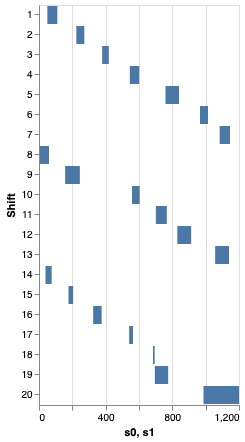

In [16]:
df14 = load_input_table("014.json")

split_col = df14["End of Shift"].str.split("/", expand=True)
df14["s1"] = split_col[0]
split_col = df14["Start of Shift"].str.split("/", expand=True)
df14["s0"] = split_col[0]

df14 = load_and_clean_table(df14)
print(df14)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": { "field": "s0", "type": "quantitative"},
        "x2": { "field": "s1", "type": "quantitative"},
        "y": { "field": "Shift", "type": "nominal"}
    }
}, df14)

    Duration  End of Shift  Period  Shift Start of Shift    s1    s0
0         60  1:50 / 18:10       1      1   0:50 / 19:10   110    50
1         48  4:32 / 15:28       1      2   3:44 / 16:16   272   224
2         40  6:59 / 13:01       1      3   6:19 / 13:41   419   379
3         56  10:01 / 9:59       1      4   9:05 / 10:55   601   545
4         81  14:00 / 6:00       1      5   12:39 / 7:21   840   759
5         48  16:54 / 3:06       1      6   16:06 / 3:54  1014   966
6         62  19:06 / 0:54       1      7   18:04 / 1:56  1146  1084
7         60  1:00 / 19:00       2      8   0:00 / 20:00    60     0
8         88  4:05 / 15:55       2      9   2:37 / 17:23   245   157
9         46  10:04 / 9:56       2     10   9:18 / 10:42   604   558
10        66  12:47 / 7:13       2     11   11:41 / 8:19   767   701
11        83  15:13 / 4:47       2     12   13:50 / 6:10   913   830
12        83  19:00 / 1:00       2     13   17:37 / 2:23  1140  1057
13        37  1:16 / 18:44       3

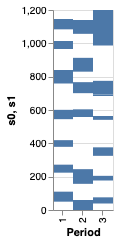

In [17]:
df15 = load_input_table("015.json")

split_col = df15["End of Shift"].str.split("/", expand=True)
df15["s1"] = split_col[0]
split_col = df15["Start of Shift"].str.split("/", expand=True)
df15["s0"] = split_col[0]

df15 = load_and_clean_table(df15)

print(df15)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "rect",
    "encoding": {
        "y": { "field": "s0", "type": "quantitative"},
        "x": { "field": "Period", "type": "nominal"},
        "y2": { "field": "s1", "type": "quantitative"},
    }
}, df15)

   Amount Revenue  Variance Variance %  Year  Year Label         c
0  773000   $773K   39000.0        +5%  2011        2011  812000.0
1  812000   $812K -445000.0       -55%  2012        2012  367000.0
2  367000   $367K  117000.0       +32%  2013        2013  484000.0
3  484000   $484K  278000.0       +57%  2014        2014  762000.0
4  762000   $762K -201000.0       -26%  2015        2015  561000.0
5  561000   $561K  213000.0       +38%  2016        2016  774000.0
6  774000   $774K       NaN             2017        2017       NaN


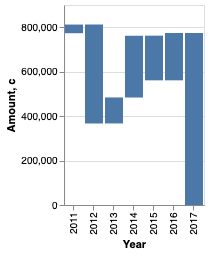

In [18]:
df16 = load_input_table("016.json")

df16["c"] = df16["Amount"] + df16["Variance"]

print(df16)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {
        "x": { "field": "Year", "type": "nominal"},
    },
    "layer": [{
        "mark": "bar",
        "encoding": {
            "y": { "field": "Amount", "type": "quantitative"},
            "y2": { "field": "c", "type": "quantitative"},
        },
    }]
}, df16)

    Actual  Projected  Year
0   1000.0        NaN  2001
1   1050.0        NaN  2002
2   1110.0        NaN  2003
3   1180.0        NaN  2004
4   1260.0        NaN  2005
5   1350.0        NaN  2006
6   1450.0        NaN  2007
7   1560.0        NaN  2008
8   1680.0        NaN  2009
9   1810.0        NaN  2010
10  1950.0        NaN  2011
11  2100.0        NaN  2012
12  2260.0        NaN  2013
13  2430.0        NaN  2014
14  2610.0        NaN  2015
15  2800.0        NaN  2016
16  3000.0        NaN  2017
17  3210.0     3210.0  2018
18     NaN     4960.0  2025
19     NaN     6510.0  2030
20     NaN    10360.0  2040


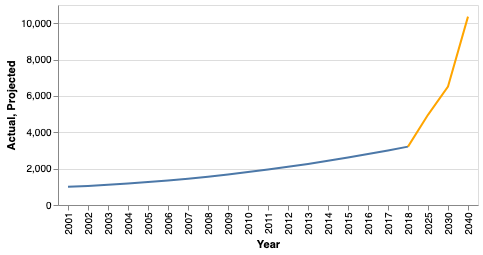

In [19]:
df17 = load_input_table("017.json")

print(df17)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {
        "x": { "field": "Year", "type": "nominal"},
    },
    "layer": [{
        "mark": "line",
        "encoding": {
            "y": { "field": "Actual", "type": "quantitative"},
        }},{
        "mark": {"type": "line", "color": "orange"},
        "encoding": {
            "y": { "field": "Projected", "type": "quantitative"},
        }
    }]
}, df17)

                 Item variable  value
0   Desktop Computers     2012     20
1             Laptops     2012     34
2            Monitors     2012     12
3            Printers     2012     78
4   Desktop Computers     2013     12
5             Laptops     2013     45
6            Monitors     2013     10
7            Printers     2013     13
8   Desktop Computers     2014     13
9             Laptops     2014     40
10           Monitors     2014     17
11           Printers     2014     90
12  Desktop Computers     2015     12
13            Laptops     2015     39
14           Monitors     2015     15
15           Printers     2015     14


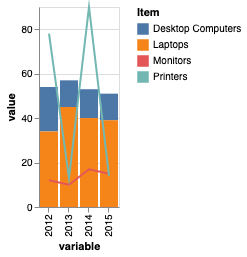

In [20]:
df18 = load_input_table("018.json")

df18 = pd.melt(df18, id_vars='Item', value_vars=["2012", "2013", "2014", "2015"])

print(df18)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {
        "x": { "field": "variable", "type": "nominal"},
    },
    "layer": [{
        "mark": "bar",
        "transform": [{"filter": "datum.Item == \"Desktop Computers\" || datum.Item == \"Laptops\""}],
        "encoding": {
            "y": { "field": "value", "type": "quantitative"},
            "color": {"field": "Item", "type": "nominal"},
        }},{
        "mark": {"type": "line"},
        "transform": [{"filter": "datum.Item != \"Desktop Computers\" && datum.Item != \"Laptops\""}],
        "encoding": {
            "y": { "field": "value", "type": "quantitative"},
            "color": {"field": "Item", "type": "nominal"},
        }
    }]
}, df18)

              cuts  Customer ID  Duration  Purchase Amount  Representative  \
0     (-0.2, 10.0]          533       533              533             533   
1     (10.0, 20.0]            0         0                0               0   
2     (20.0, 30.0]            0         0                0               0   
3     (30.0, 40.0]            0         0                0               0   
4     (40.0, 50.0]           72        72               72              72   
5     (50.0, 60.0]          118       118              118             118   
6     (60.0, 70.0]          127       127              127             127   
7     (70.0, 80.0]          126       126              126             126   
8     (80.0, 90.0]          123       123              123             123   
9    (90.0, 100.0]          113       113              113             113   
10  (100.0, 110.0]          132       132              132             132   
11  (110.0, 120.0]          115       115              115      

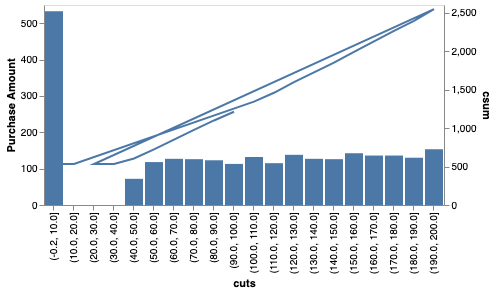

In [21]:
df19 = load_input_table("019.json")

df19["cuts"] = pd.cut(df19['Purchase Amount'], 20)
df19 = df19.groupby(['cuts']).count().reset_index()
df19["csum"] = df19["Purchase Amount"].cumsum()

print(df19)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {
        "x": { "field": "cuts", "type": "ordinal", "sort": "none"},
    },
    "layer": [{
        "mark": "bar",
        "encoding": {
            "y": { "field": "Purchase Amount", "type": "quantitative"},
        }
    },{
        "mark": "line",
        "encoding": {
            "y": { "field": "csum", "type": "quantitative"},
        }
    }],
    "resolve": {"scale": {"y": "independent"}}
}, df19)

     Amount    Category         Country        Date  Order ID   Product
0      4270  Vegetables   United States    1/6/2012         1   Carrots
1      8239  Vegetables  United Kingdom    1/7/2012         2  Broccoli
2       617       Fruit   United States    1/8/2012         3    Banana
3      8384       Fruit          Canada   1/10/2012         4    Banana
4      2626  Vegetables         Germany   1/10/2012         5     Beans
5      3610       Fruit   United States   1/11/2012         6    Orange
6      9062  Vegetables       Australia   1/11/2012         7  Broccoli
7      6906       Fruit     New Zealand   1/16/2012         8    Banana
8      2417       Fruit          France   1/16/2012         9     Apple
9      7431       Fruit          Canada   1/16/2012        10     Apple
10     8250       Fruit         Germany   1/16/2012        11    Banana
11     7012  Vegetables   United States   1/18/2012        12  Broccoli
12     1903  Vegetables         Germany   1/20/2012        13   

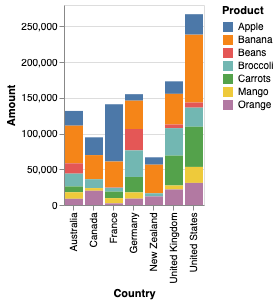

In [22]:
df20 = load_input_table("020.json")

print(df20)

df20 = df20.groupby(['Product', "Country"])["Amount"].sum().reset_index()

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": { "field": "Country", "type": "nominal"},
        "color": { "field": "Product", "type": "nominal"},
        "y": { "field": "Amount", "type": "quantitative"},
        #"column": { "field": "Country", "type": "nominal"},
        
    }
}, df20)

           Country  Total Result  variable    value
0        Australia         40492     Beans  14433.0
1           Canada         12407     Beans      NaN
2           France         15125     Beans    680.0
3          Germany         88738     Beans  29905.0
4      New Zealand          4390     Beans      NaN
5   United Kingdom         85351     Beans   5100.0
6    United States         90162     Beans   7163.0
8        Australia         40492  Broccoli  17953.0
9           Canada         12407  Broccoli  12407.0
10          France         15125  Broccoli   5341.0
11         Germany         88738  Broccoli  37197.0
12     New Zealand          4390  Broccoli   4390.0
13  United Kingdom         85351  Broccoli  38436.0
14   United States         90162  Broccoli  26715.0
16       Australia         40492   Carrots   8106.0
17          Canada         12407   Carrots      NaN
18          France         15125   Carrots   9104.0
19         Germany         88738   Carrots  21636.0
20     New Z

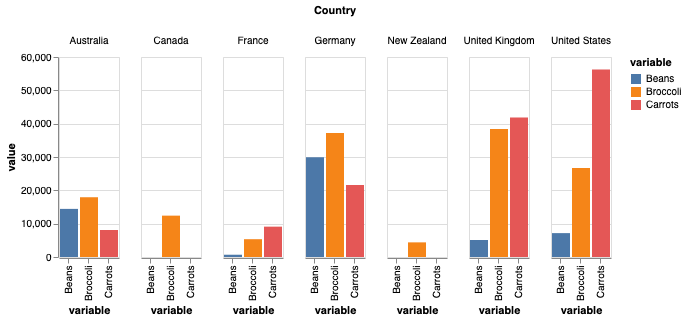

In [23]:
df21 = load_input_table("021.json")

df21 = pd.melt(df21, id_vars=['Country', "Total Result"], value_vars=["Beans", "Broccoli", "Carrots"])
df21 = df21[df21["Country"] != "Total Result"]

print(df21)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": { "field": "variable", "type": "nominal"},
        "color": { "field": "variable", "type": "nominal"},
        "y": { "field": "value", "type": "quantitative"},
        "column": { "field": "Country", "type": "nominal"},
        
    }
}, df21)

     #  Coverage                       Event  Event_line  Year
0    1        81                                     NaN  1995
1    2        81                                     NaN  1996
2    3        81  Medicaid coverage for kids        81.0  1997
3    4        82                                     NaN  1998
4    5        81      Patient bill of rights        81.0  1999
5    6        82                                     NaN  2000
6    7        85                                     NaN  2001
7    8        85                                     NaN  2002
8    9        84             Medicare Part D        84.0  2003
9   10        83                                     NaN  2004
10  11        83                                     NaN  2005
11  12        83                                     NaN  2006
12  13        84                                     NaN  2007
13  14        83                                     NaN  2008
14  15        83                                     Na

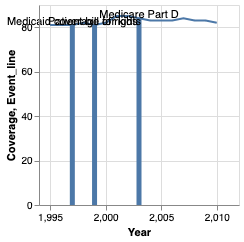

In [24]:
df22 = load_input_table("022.json")

print(df22)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": { "x": { "field": "Year", "type": "quantitative"}},
    "layer":[{
        "mark": "line",
        "encoding": {
            "y": { "field": "Coverage", "type": "quantitative"}
        }
    },{
        "mark": "bar",
        "encoding": {
            "y": { "field": "Event_line", "type": "quantitative"}
        }
    },{
        "mark": "text",
        "encoding": {
            "y": { "field": "Event_line", "type": "quantitative"},
            "text": { "field": "Event", "type": "nominal"},
        }
    }]
}, df22)

        DATE   DESCRIPTION  POSITION
0    5/10/18      Kick Off         1
1     6/7/18   Milestone 1         2
2    7/21/18   Milestone 2         1
3     8/1/18  Checkpoint A         4
4    9/20/18   Milestone 3         3
5   10/30/18   Milestone 4         2
6   12/20/18  Checkpoint B         3
7    1/30/19   Milestone 5         4
8    2/10/19   Milestone 6         1
9    3/30/19   Milestone 7         2
10   5/20/19  Checkpoint C         3
11   5/30/19      Sign Off         1


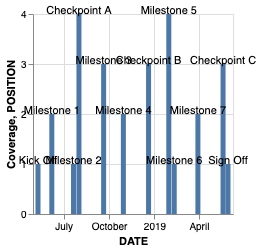

In [25]:
df23 = load_input_table("023.json")

print(df23)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": { "x": { "field": "DATE", "type": "temporal"}},
    "layer":[{
        "mark": "line",
        "encoding": {
            "y": { "field": "Coverage", "type": "quantitative"}
        }
    },{
        "mark": "bar",
        "encoding": {
            "y": { "field": "POSITION", "type": "quantitative"}
        }
    },{
        "mark": "text",
        "encoding": {
            "y": { "field": "POSITION", "type": "quantitative"},
            "text": { "field": "DESCRIPTION", "type": "nominal"},
        }
    }]
}, df23)

   Duration           Parts Start Date  id   End Date
0        10      Foundation 2000-06-01   0 2000-06-11
1         7           Walls 2000-06-12   1 2000-06-19
2        10            Roof 2000-06-20   2 2000-06-30
3         5  Windows, Doors 2000-07-01   3 2000-07-06
4         3        Plumbing 2000-07-07   4 2000-07-10
5         3        Electric 2000-07-07   5 2000-07-10
6         2        Painting 2000-07-11   6 2000-07-13
7         2        Flooring 2000-07-13   7 2000-07-15


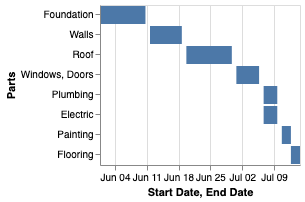

In [26]:
df24 = load_input_table("024.json")

df24['id'] = df24.index
df24["Start Date"] = pd.to_datetime(df24["Start Date"], infer_datetime_format=True)
df24["End Date"] = df24["Start Date"] + pd.TimedeltaIndex(df24['Duration'], unit="D")

print(df24)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "y": { "field": "Parts", "type": "nominal", "sort": "null"},
        "x": { "field": "Start Date", "type": "temporal"},
        "x2": { "field": "End Date", "type": "temporal"}
    }
}, df24)

      Complaint Type  Count  cumsum
1         Overpriced    789     789
9     Small portions    621    1410
7          Wait time    109    1519
2  Food is tasteless     65    1584
8      No atmosphere     45    1629
5          Not clean     30    1659
0          Too noisy     27    1686
4  Food is too salty     15    1701
6   Unfriendly staff     12    1713
3     Food not fresh      9    1722


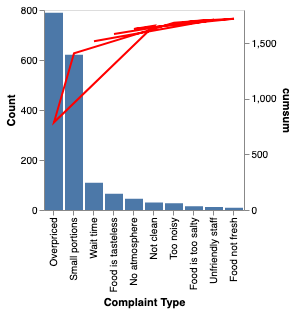

In [27]:
df25 = load_input_table("025.json")

df25 = df25.sort_values(by='Count', ascending=False)
df25["cumsum"] = df25["Count"].cumsum()

print(df25)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": { "x": { "field": "Complaint Type", "type": "nominal", "sort": False}},
    "layer":[{
        "mark": "bar",
        "encoding": {
            "y": { "field": "Count", "type": "quantitative"}
        }
    },{
        "mark": {"type": "line", "color": "red"},
        "encoding": {
            "y": { "field": "cumsum", "type": "quantitative"},
        }
    }],
  "resolve": {"scale": {"y": "independent"}}
}, df25)

          Period  variable    value
0         Actual         0      120
1   Interval = 2         0     #N/A
2   Interval = 4         0     #N/A
3   Interval = 6         0     #N/A
4         Actual         1      150
5   Interval = 2         1      135
6   Interval = 4         1     #N/A
7   Interval = 6         1     #N/A
8         Actual         2      240
9   Interval = 2         2      195
10  Interval = 4         2     #N/A
11  Interval = 6         2     #N/A
12        Actual         3      540
13  Interval = 2         3      390
14  Interval = 4         3    262.5
15  Interval = 6         3     #N/A
16        Actual         4      210
17  Interval = 2         4      375
18  Interval = 4         4      285
19  Interval = 6         4     #N/A
20        Actual         5      380
21  Interval = 2         5      295
22  Interval = 4         5    342.5
23  Interval = 6         5  273.333
24        Actual         6      120
25  Interval = 2         6      250
26  Interval = 4         6  

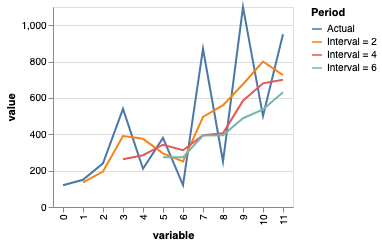

In [28]:
df27 = load_input_table("027.json")

df27 = pd.melt(df27, id_vars=['Period'], value_vars=["0", "1", "2", "3", "4", '5', '6', "7", "8", "9", "10", "11"])
df27 = load_and_clean_table(df27)
print(df27)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "line",
    "encoding": {
        "x": { "field": "variable", "type": "ordinal"},
        "y": { "field": "value", "type": "quantitative"},
        "color": { "field": "Period", "type": "nominal"},
    }
   
}, df27)

        cuts  Number of students
0    (0, 20]                   1
1   (20, 25]                   8
2   (25, 30]                   2
3   (30, 35]                   2
4   (35, 40]                   3
5  (40, 100]                   2


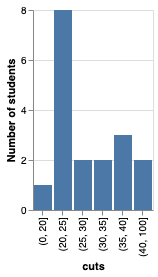

In [29]:
df28 = load_input_table("028.json")

df28["cuts"] = pd.cut(df28['Number of students'], [0, 20, 25, 30, 35, 40, 100])
df28 = df28.groupby(['cuts']).count().reset_index()

print(df28)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": { "field": "cuts", "type": "nominal"},
        "y": { "field": "Number of students", "type": "quantitative"},
    }
   
}, df28)

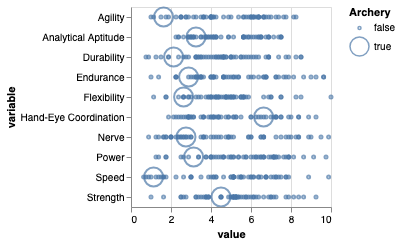

In [30]:
df29 = load_input_table("029.json")

df29 = pd.melt(df29, id_vars=['Sport', "Rank"], value_vars=["Endurance", "Strength", "Power", "Speed", "Agility", "Flexibility", "Nerve", "Durability", "Hand-Eye Coordination", "Analytical Aptitude"])
df29["Archery"] = df29["Sport"] == "Archery"

#print(df29)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "point",
    "encoding": {
        "x": { "field": "value", "type": "quantitative"},
        "y": { "field": "variable", "type": "nominal"},
        "size": {"field": "Archery", 'type': "nominal"}
    }
   
}, df29)

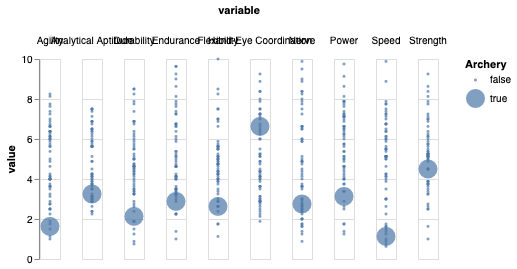

In [31]:
df30 = load_input_table("030.json")

df30 = pd.melt(df30, id_vars=['Sport', "Rank"], 
                     value_vars=["Endurance", "Strength", "Power", "Speed", "Agility", "Flexibility", "Nerve", "Durability", "Hand-Eye Coordination", "Analytical Aptitude"])
df30["Archery"] = df30["Sport"] == "Archery"


VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "circle",
    "encoding": {
        "y": { "field": "value", "type": "quantitative"},
        "column": {"field": "variable", 'type': "nominal"},
        "size": {"field": "Archery", 'type': "nominal"}
    }
   
}, df30)

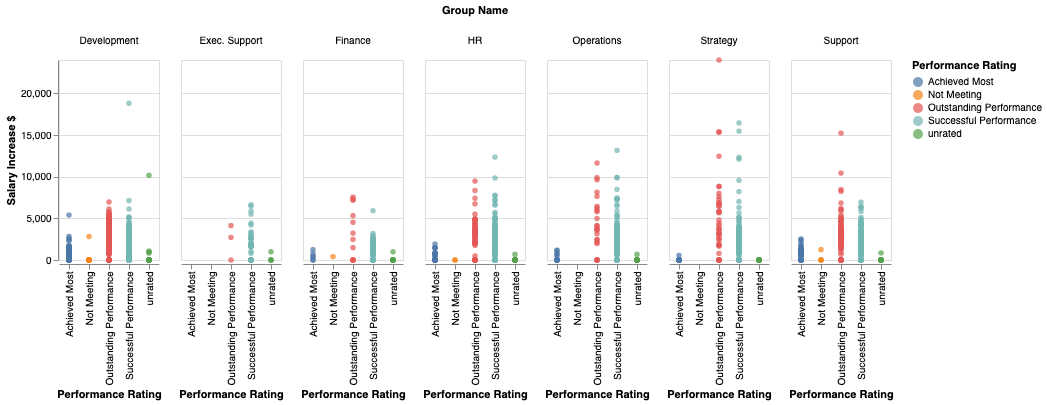

In [32]:
df31 = load_input_table("031.json")

#print(df31)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "circle",
    "encoding": {
        "x": { "field": "Performance Rating", "type": "nominal"},
        "color": { "field": "Performance Rating", "type": "nominal"},
        "column": {"field": "Group Name", 'type': "nominal"},
        "y": {"field": "Salary Increase $", 'type': "quantitative"}
    }
   
}, df31)

                               activity variable     value
0                     Playing billiards        0  0.000032
1                               Dancing        0  0.000168
2                              Softball        0  0.000000
3                               Bowling        0  0.000012
4                    Playing volleyball        0  0.000000
5         Participating in martial arts        0  0.000000
6                Playing racquet sports        0  0.000000
7                                Biking        0  0.000000
8       Weightlifting/strength training        0  0.000026
9                            Doing yoga        0  0.000005
10                       Playing soccer        0  0.000000
11                     Playing football        0  0.000000
12                   Playing basketball        0  0.000000
13                     Playing baseball        0  0.000000
14                              Hunting        0  0.000026
15               Vehicle touring/racing        0  0.0000

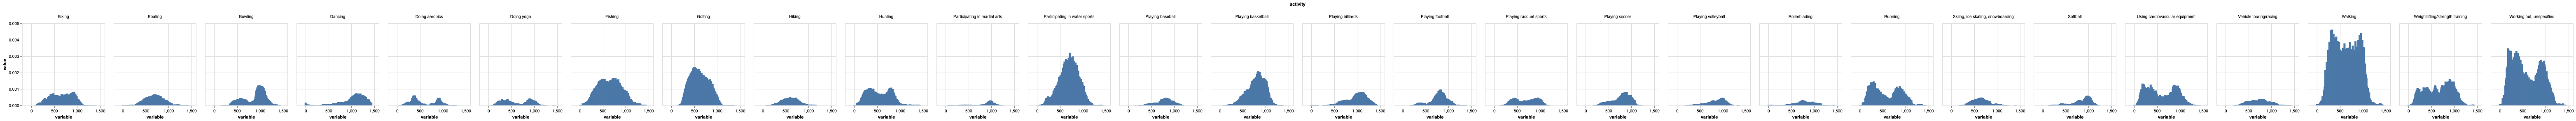

In [33]:
df33 = load_input_table("033.json")

df33 = pd.melt(df33, id_vars="activity", value_vars=['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', '95', '100', '105', '110', '115', '120', '125', '130', '135', '140', '145', '150', '155', '160', '165', '170', '175', '180', '185', '190', '195', '200', '205', '210', '215', '220', '225', '230', '235', '240', '245', '250', '255', '260', '265', '270', '275', '280', '285', '290', '295', '300', '305', '310', '315', '320', '325', '330', '335', '340', '345', '350', '355', '360', '365', '370', '375', '380', '385', '390', '395', '400', '405', '410', '415', '420', '425', '430', '435', '440', '445', '450', '455', '460', '465', '470', '475', '480', '485', '490', '495', '500', '505', '510', '515', '520', '525', '530', '535', '540', '545', '550', '555', '560', '565', '570', '575', '580', '585', '590', '595', '600', '605', '610', '615', '620', '625', '630', '635', '640', '645', '650', '655', '660', '665', '670', '675', '680', '685', '690', '695', '700', '705', '710', '715', '720', '725', '730', '735', '740', '745', '750', '755', '760', '765', '770', '775', '780', '785', '790', '795', '800', '805', '810', '815', '820', '825', '830', '835', '840', '845', '850', '855', '860', '865', '870', '875', '880', '885', '890', '895', '900', '905', '910', '915', '920', '925', '930', '935', '940', '945', '950', '955', '960', '965', '970', '975', '980', '985', '990', '995', '1000', '1005', '1010', '1015', '1020', '1025', '1030', '1035', '1040', '1045', '1050', '1055', '1060', '1065', '1070', '1075', '1080', '1085', '1090', '1095', '1100', '1105', '1110', '1115', '1120', '1125', '1130', '1135', '1140', '1145', '1150', '1155', '1160', '1165', '1170', '1175', '1180', '1185', '1190', '1195', '1200', '1205', '1210', '1215', '1220', '1225', '1230', '1235', '1240', '1245', '1250', '1255', '1260', '1265', '1270', '1275', '1280', '1285', '1290', '1295', '1300', '1305', '1310', '1315', '1320', '1325', '1330', '1335', '1340', '1345', '1350', '1355', '1360', '1365', '1370', '1375', '1380', '1385', '1390', '1395', '1400', '1405', '1410', '1415', '1420', '1425', '1430', '1435'])

print(df33)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "bar",
    "encoding": {
        "x": { "field": "variable", "type": "quantitative"},
        "column": {"field": "activity", 'type': "nominal"},
        "y": {"field": "value", 'type': "quantitative"}
    }
}, df33)

   Timeline                variable    value
11   Jun-16                Forecast     1097
12   Jul-16                Forecast  939.925
13   Aug-16                Forecast  924.496
14   Sep-16                Forecast  909.067
26   Jun-16  Lower Confidence Bound     1097
27   Jul-16  Lower Confidence Bound -1913.98
28   Aug-16  Lower Confidence Bound -1952.33
29   Sep-16  Lower Confidence Bound -1990.86
41   Jun-16  Upper Confidence Bound     1097
42   Jul-16  Upper Confidence Bound  3793.83
43   Aug-16  Upper Confidence Bound  3801.32
44   Sep-16  Upper Confidence Bound  3808.99
45   Jul-15                  Values      436
46   Aug-15                  Values      500
47   Sep-15                  Values      805
48   Oct-15                  Values     5124
49   Nov-15                  Values     1674
50   Dec-15                  Values      300
51   Jan-16                  Values      265
52   Feb-16                  Values      742
53   Mar-16                  Values     1955
54   Apr-1

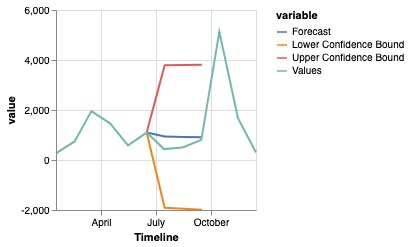

In [34]:
df34 = load_input_table("034.json")

df34 = pd.melt(df34, id_vars="Timeline", value_vars=["Forecast", "Lower Confidence Bound", "Upper Confidence Bound", "Values"])
df34 = df34[df34["value"] != ""]

print(df34)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": "line",
    "encoding": {
        "x": { "field": "Timeline", "type": "temporal"},
        "color": {"field": "variable", 'type': "nominal"},
        "y": {"field": "value", 'type': "quantitative"}
    }
}, df34)

   DATA variable  value
0     A    Lower     80
1     B    Lower    103
2     C    Lower    106
3     D    Lower     75
4     E    Lower     85
5     A    Upper    116
6     B    Upper    138
7     C    Upper    157
8     D    Upper     85
9     E    Upper    102
10    A    Value    100
11    B    Value    120
12    C    Value    140
13    D    Value     80
14    E    Value     90


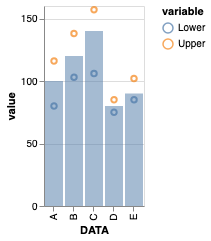

In [35]:
df35 = load_input_table("035.json")
df35 = pd.melt(df35, id_vars=["DATA"], value_vars=["Lower", "Upper", "Value"])
print(df35)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {"x": {"field": "DATA", "type": "nominal"}},
    "layer": [
        {
          "mark": {"type": "bar", "opacity": 0.5},
          "transform": [{"filter": "datum.variable == \"Value\""}],
          "encoding": { "y": { "field": "value", "type": "quantitative" }}
        },
        {
          "mark": {"type": "point"},
          "transform": [{"filter": "datum.variable != \"Value\""}],
          "encoding": {
            "y": {"field": "value", "type": "quantitative"},
            "color": {"field": "variable", "type": "nominal"}
          }
        }
    ]
}, df35)

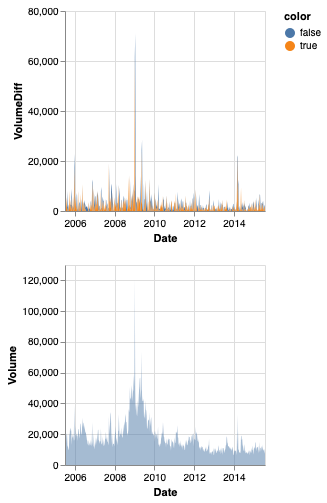

In [36]:
df36 = load_input_table("036.json")
df36["VolumeDiff"] = df36["Volume"].diff()
df36["color"] = df36['VolumeDiff'] > 0
df36["VolumeDiff"] = df36["VolumeDiff"].abs()

#print(df36)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "vconcat": [
        {
          "mark": {"type": "area"},
          "encoding": {
              "x": {"field": "Date", "type": "temporal"},
            "y": {"field": "VolumeDiff", "type": "quantitative"},
            "color": {"field": "color", "type": "nominal"}
          }
        },
        {
          "mark": {"type": "area", "opacity": 0.5},
          "encoding": { "y": { "field": "Volume", "type": "quantitative" },
                        "x": {"field": "Date", "type": "temporal"}}
        }
    ]
}, df36)

    TOTAL                     Category variable     value
0     645              HOME APPLIANCES    <-10% -0.300775
1     568                    COMPUTERS    <-10% -0.306338
2     355         CAMERAS & CAMCORDERS    <-10% -0.309859
3     265                  CELL PHONES    <-10% -0.301887
4     205                   TV & VIDEO    <-10% -0.302439
5     166                 GAMES & TOYS    <-10% -0.391566
6     100                        AUDIO    <-10% -0.340000
7      90  MUSIC, MOVIES & AUDIO BOOKS    <-10% -0.166667
8     645              HOME APPLIANCES      <0% -0.215504
9     568                    COMPUTERS      <0% -0.207746
10    355         CAMERAS & CAMCORDERS      <0% -0.264789
11    265                  CELL PHONES      <0% -0.237736
12    205                   TV & VIDEO      <0% -0.219512
13    166                 GAMES & TOYS      <0% -0.204819
14    100                        AUDIO      <0% -0.190000
15     90  MUSIC, MOVIES & AUDIO BOOKS      <0% -0.288889
16    645     

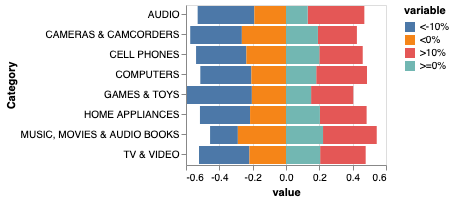

In [37]:
df37 = load_input_table("037.json")

df37 = pd.melt(df37, id_vars=["TOTAL", "Category"], value_vars=["<-10%", "<0%", ">10%", ">=0%"])
df37['value'].mask(df37['variable'] == "<-10%", -df37["value"], inplace=True)
df37['value'].mask(df37['variable'] == "<0%", -df37["value"], inplace=True)

df37["value"] = df37["value"] / df37["TOTAL"]

print(df37)
VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "mark": {"type": "bar"},
    "encoding": {
        "color": {"field": "variable", "type": "nominal"},
        "y": {"field": "Category", "type": "nominal"},
        "x": { "field": "value", "type": "quantitative"}    
    }
}, df37)

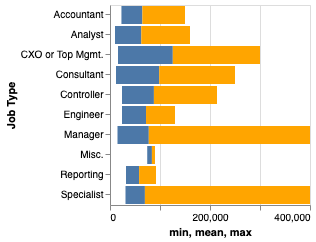

In [38]:
df38 = load_input_table("038.json")

df38_0 = df38.groupby("Job Type")['Salary in USD'].mean()
df38_1 = df38.groupby("Job Type")['Salary in USD'].max()
df38_2 = df38.groupby("Job Type")['Salary in USD'].min()

df38 = pd.concat([df38_0, df38_1, df38_2], axis=1).reset_index()
df38.columns = ["Job Type", "mean", "max", "min"]

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {
            "y": {"field": "Job Type", "type": "nominal"} },
    "layer":[{
        "mark": {"type": "bar"},
        "encoding": {
            "y": {"field": "Job Type", "type": "nominal"},
            "x": { "field": "min", "type": "quantitative"},
            "x2": { "field": "mean", "type": "quantitative"}  
        }}, {
        "mark": {"type": "bar", "color": "orange"},
        "encoding": {
            "y": {"field": "Job Type", "type": "nominal"},
            "x": { "field": "mean", "type": "quantitative"},
            "x2": { "field": "max", "type": "quantitative"}  
        }
    }]
}, df38)

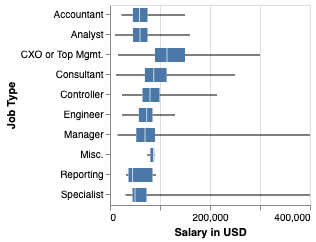

In [39]:
df38 = load_input_table("038.json")

VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": {
    "type": "boxplot",
    "extent": "min-max"
  },
  "encoding": {
    "x": {"field": "Salary in USD","type": "quantitative"},
    "y": {
      "field": "Job Type",
      "type": "nominal",
    }
  }
}
, df38)

    Year    loc  Bisc  Choc
0   2007  NORTH   6.0  14.0
1   2007  SOUTH   4.0  10.0
2   2007   WEST   4.0   6.0
3   2008  NORTH   6.7  18.0
4   2008  SOUTH   5.0  11.0
5   2008   WEST   5.0  10.0
6   2009  NORTH   7.0  19.0
7   2009  SOUTH   5.7  14.0
8   2009   WEST   5.7  12.0
9   2010  NORTH   8.0  21.0
10  2010  SOUTH   6.0  16.0
11  2010   WEST   6.0  15.0


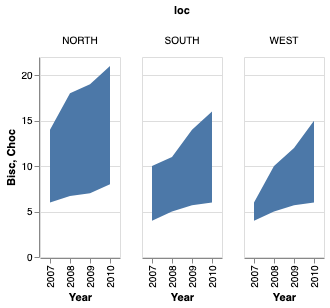

In [40]:
df39 = load_input_table("039.json")

df39 = pd.melt(df39, id_vars=["Year"], 
               value_vars=["NORTH-Bisc", "NORTH-Choc", "SOUTH-Bisc", "SOUTH-Choc", "WEST-Bisc", "WEST-Choc"])
split_col = df39["variable"].str.split("-", expand=True)
df39["loc"] = split_col[0]
df39["type"] = split_col[1]
df39 = df39.pivot_table(index=["Year", "loc"], columns='type', values=['value']).reset_index()
df39.columns = ["Year", "loc", "Bisc", "Choc"]

print(df39)

VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": {
    "type": "area"
  },
  "encoding": {
    "x": {"field": "Year","type": "ordinal"},
    "y": { "field": "Bisc", "type": "quantitative" },
    "y2": { "field": "Choc", "type": "quantitative" },
    "column": { "field": "loc", "type": "nominal" }
  }
}
, df39)

    Value Win / Loss  id  end  start
0      10        Win   0   10      0
1       2       Loss   1   12     10
2      12        Win   2   24     12
3       4       Loss   3   28     24
4       5        Win   4   33     28
5      16       Loss   5   49     33
6       9        Win   6   58     49
7      18       Loss   7   76     58
8      12        Win   8   88     76
9       3       Loss   9   91     88
10      4        Win  10   95     91
11      4       Loss  11   99     95
12      1        Win  12  100     99


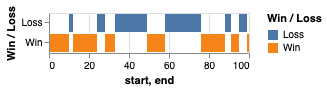

In [41]:
df40 = load_input_table("040.json")
df40["id"] = df40.index

df40["end"] = df40["Value"].cumsum()
df40["start"] = df40["end"] - df40["Value"]

print(df40)

VegaLite({
  "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
  "mark": {
    "type": "bar"
  },
  "encoding": {
    "x": {"field": "start","type": "quantitative"},
    "x2": {"field": "end","type": "quantitative"},
    "color": { "field": "Win / Loss", "type": "nominal" },
    "y": { "field": "Win / Loss", "type": "nominal" }
  }
}
, df40)

   Totals Value  alpha  beta  gamma
0       7     A      2     2      3
1       8     B      2     3      3
2       9     c      3     3      3
3       9     D      3     4      2
4       9     E      4     3      2


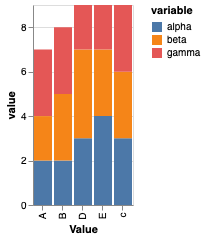

In [42]:
df13 = load_input_table("013.json")

print(df13)

df13 = pd.melt(df13, id_vars=["Totals", "Value"], value_vars=["alpha", "beta", "gamma"])
df13['cumsum'] = df13.groupby("Value")['value'].transform(pd.Series.cumsum)

#print(df13)

VegaLite({
    "$schema": "https://vega.github.io/schema/vega-lite/v3.json",
    "encoding": {"x": { "field": "Value", "type": "nominal" }},
    "layer": [{
        "mark": "bar",
        "encoding": {
            "y": { "field": "value", "type": "quantitative"},
            "color": {"field": "variable", "type": "nominal"},
            "order": {"field": "variable", "type": "quantitative", "sort": "ascending"}
        }
    }]
}, df13)